# AutoML: Data Science Made Really Easy

In [2]:
import pandas as pd
import featuretools as ft
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from hpsklearn import HyperoptEstimator, any_classifier
import numpy as np
from collections import defaultdict
import seaborn as sns
import pickle

%matplotlib inline

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [200]:
train_df = pd.read_csv("data/train.csv")
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df['Cabin'] = train_df["Cabin"].str.get(0)
train_df['LastName'] = train_df['Name'].str.split(", ").apply(lambda x: x[0])
train_df['Honorific'] = train_df['Name'].str.extract(" ([a-zA-z]+)")
train_df['TicketPrefix'] = train_df['Ticket'].str.extract("(.+) ")
train_df['TicketNumber'] = train_df['Ticket'].str.extract("([0-9]+)$").astype(float)
train_df.sample(5)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Honorific,TicketPrefix,TicketNumber
463,464,0,2,"Milling, Mr. Jacob Christian",male,48.0,0,0,234360,13.0000,NaN,S,Milling,Mr,NaN,234360.0
697,698,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,Mullens,Miss,NaN,35852.0
362,363,0,3,"Barbara, Mrs. (Catherine David)",female,45.0,0,1,2691,14.4542,NaN,C,Barbara,Mrs,NaN,2691.0
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A,S,Rood,Mr,NaN,113767.0
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S,Hagland,Mr,NaN,65304.0


In [201]:
train_df = train_df.drop(columns=["Name", "Cabin", "Ticket"])
train_features = train_df.drop(columns=["Survived"])
train_target = train_df["Survived"]

In [202]:
train_features.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,LastName,Honorific,TicketPrefix,TicketNumber
759,760,1,female,33.0,0,0,86.5000,S,Rothes,the,NaN,110152.0
793,794,1,male,NaN,0,0,30.6958,C,Hoyt,Mr,PC,17600.0
39,40,3,female,14.0,1,0,11.2417,C,Nicola-Yarred,Miss,NaN,2651.0
393,394,1,female,23.0,1,0,113.2750,C,Newell,Miss,NaN,35273.0
565,566,3,male,24.0,2,0,24.1500,S,Davies,Mr,A/4,48871.0


In [131]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical})
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="LastName")

Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked

In [132]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


In [133]:
imputer = Imputer(strategy='median')
imputed_matrix = imputer.fit_transform(feature_matrix)

In [134]:
model = "kitchen-sink"
name = f"100_{model}_titanic_dfs"

estim = HyperoptEstimator(classifier=any_classifier(model),
                          max_evals=100,
                          trial_timeout=60,
                          fit_increment_dump_filename=f"results/models/{name}.pickle",
                          verbose=0,
                          seed=42
                          )

estim.fit(imputed_matrix,
          train_target,
          n_folds=5,    
          random_state=41,
          )

train_loss = estim.trials.best_trial["result"]["loss"]

print(train_loss)
print(estim.best_model())

with open(f"results/models/{train_loss:.3}_{name}_estimator.pickle", "wb+") as estimator:
    pickle.dump(estim, estimator)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.16722783389450058
{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9650688736808748,
       colsample_bytree=0.7263151008928389, gamma=1.6691357743417827,
       learning_rate=0.2168510528743872, max_delta_step=0, max_depth=10,
       min_child_weight=10, missing=nan, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01712777137082772, reg_lambda=2.8896229565510203,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.788870981192162), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


In [135]:
trial_results = defaultdict(list)
for trial in range(0,100):
    if 'loss' in estim.trials.trials[trial]['result']:
        trial_results['loss'].append(estim.trials.trials[trial]['result']['loss'])
        trial_results['loss_variance'].append(estim.trials.trials[0]['result']['loss_variance'])
    else:
        print(estim.trials.trials[trial]['result'])
        trial_results['loss'].append(None)
        trial_results['loss_variance'].append(None)
    for key, value in estim.trials.trials[trial]['misc']['idxs'].items():
        if value and "kitchen-sink." in key:
            trial_results['algorithm_type'].append(key.split(".")[1])
            break

{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}


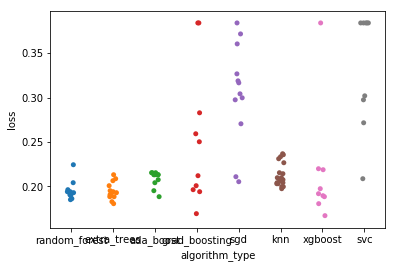

In [136]:
trial_df = pd.DataFrame(trial_results)
sns.stripplot(data = trial_df, x='algorithm_type', y='loss', jitter=True)

In [64]:
for property, value in vars(features[40]).items():
    print(property, ": ", value)

parent_entity :  Entity: sexes
  Variables:
    Sex (dtype: index)
  Shape:
    (2, 1)
_variable_type :  <class 'featuretools.variable_types.variable.Numeric'>
entity_id :  titanic
entityset :  Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked
base_features :  [<Feature: STD(titanic.Age)>]
additional_attributes :  {}


In [75]:
features[40]

<Feature: sexes.STD(titanic.Age)>

In [94]:
train_df.groupby("Sex").agg([np.nanmean, np.nanstd, np.nanmin, np.nanmax])

PassengerId                            Survived                   \
           nanmean      nanstd nanmin nanmax   nanmean    nanstd nanmin   
Sex                                                                       
female  431.028662  256.437007      2    889  0.742038  0.437513      0   
male    454.147314  257.262918      1    891  0.188908  0.391436      0   

                 Pclass              ...     SibSp            Parch            \
       nanmax   nanmean    nanstd    ...    nanmin nanmax   nanmean    nanstd   
Sex                                  ...                                        
female      1  2.159236  0.855924    ...         0      8  0.649682  1.021216   
male        1  2.389948  0.812875    ...         0      8  0.235702  0.611763   

                           Fare                              
       nanmin nanmax    nanmean     nanstd nanmin    nanmax  
Sex                                                          
female      0      6  44.479818  57.905271   6.75  512.3292  
male        0      5  25.523893  43.100865   0.00  512.3292  

[2 rows x 28 columns]

## Testing

In [149]:
test_df = pd.read_csv("data/test.csv")
test_df["Pclass"] = test_df["Pclass"].astype("category")

In [138]:
test_df = test_df.drop(columns=["Name", "Cabin", "Ticket"])

In [139]:
ft.save_features(features, "results/encoded_features.pkl")

In [140]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=test_df,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical})
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

test_features = ft.load_features("results/encoded_features.pkl", es)

In [142]:
test_matrix = ft.calculate_feature_matrix(test_features)

In [144]:
test_matrix = imputer.transform(test_matrix)

In [148]:
estim.predict(test_matrix)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [156]:
submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'],
              'Survived': estim.predict(test_matrix)})

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [159]:
submission_df.to_csv("results/ft_hpsklearn_submission.csv", index=False)

## More Features

In [160]:
train_df = pd.read_csv("data/train.csv")

In [168]:
train_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else np.nan)

0      NaN
1        C
2      NaN
3        C
4      NaN
5      NaN
6        E
7      NaN
8      NaN
9      NaN
10       G
11       C
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21       D
22     NaN
23       A
24     NaN
25     NaN
26     NaN
27       C
28     NaN
29     NaN
      ... 
861    NaN
862      D
863    NaN
864    NaN
865    NaN
866    NaN
867      A
868    NaN
869    NaN
870    NaN
871      D
872      B
873    NaN
874    NaN
875    NaN
876    NaN
877    NaN
878    NaN
879      C
880    NaN
881    NaN
882    NaN
883    NaN
884    NaN
885    NaN
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object